In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def u(x: np.float64 | np.ndarray, epsilon: np.float64) -> np.ndarray:
    """The original function $u(x)$ of Exercise 06 Problem 3."""

    def temp_func(x: np.float64 | np.ndarray) -> np.float64 | np.ndarray:
        return np.exp(-x / epsilon)

    temp = temp_func(np.float64(1))

    return np.where(
        np.logical_or(x == 0, x == 1),
        np.float64(0),
        x - (temp_func(1 - x) - temp) / (1 - temp),
    )


u(np.array([0, 0.5, 1]), np.float64(1))

array([0.        , 0.12245933, 0.        ])

In [3]:
def gen_A(n: int) -> np.ndarray:
    """Generate the matrix A of the linear system of equations Au=p."""
    n = n - 1
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2
        if i > 0:
            A[i, i - 1] = -1
        if i < n - 1:
            A[i, i + 1] = -1
    return A * ((n + 1) ** 2)


gen_A(5)

array([[ 50., -25.,   0.,   0.],
       [-25.,  50., -25.,   0.],
       [  0., -25.,  50., -25.],
       [  0.,   0., -25.,  50.]])

$$
-u''(x) = f(x) = \frac{1-u'(x)}{\epsilon}
$$


In [4]:
def f(
    x: np.float64 | np.ndarray, epsilon: np.float64, h: np.float64
) -> np.float64 | np.ndarray:
    """The right-hand side of the differential equation."""
    return (1 - (u(x, epsilon) - u(x - h, epsilon)) / h) / epsilon

In [5]:
def gen_real_val(
    n: int,
    h: np.float64,
    a: np.float64,
    epsilon: np.float64,
) -> np.ndarray:
    """Generate the values of the function u at the points x_i shape (n-1, 1)."""
    y = np.zeros(n - 1)
    for i in range(n - 1):
        y[i] = -u(a + (i + 1) * h, epsilon) * (h**2)
    return y.reshape((n - 1, 1))

In [6]:
def gen_est_val(
    n: int,
    h: np.float64,
    a: np.float64,
    epsilon: np.float64,
) -> np.ndarray:
    """Generate the values of the function f at the points x_i shape (1, n-1)."""
    y = np.zeros(n - 1)
    for i in range(n - 1):
        y[i] = -f(a + (i + 1) * h, epsilon, h) * (h**2)
    return y

In [7]:
def gen_p(n: int, f_ls: np.ndarray, a: np.float64, b: np.float64) -> np.ndarray:
    """Generate the vector p of the linear system of equations Au=p."""
    p = np.zeros((n - 1, 1))
    p[0] = f_ls[0] + a * (n**2)
    for i in range(1, n - 2):
        p[i] = f_ls[i]
    p[n - 2] = f_ls[n - 2] + b * (n**2)
    return p.reshape(n - 1, 1)

In [8]:
def gen_matrix(
    n: int, h: np.float64, a: np.float64, b: np.float64, epsilon: np.float64
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generate the matrix A and the vector p of the linear system of equations Au=p.

    Args:
    ----
    a: u(0)
    b: u(1)
    epsilon: parameter of the original function u(x)
    h: Dtep size
    n: Number of intervals

    Returns:
    -------
    A: matrix A of the linear system of equations Au=p
    p: vector p of the linear system of equations Au=p

    """
    f_ls = gen_est_val(n, h, a, epsilon)
    p = gen_p(n, f_ls, a, b)
    return gen_A(n), p

In [9]:
def solve(
    n: int, h: np.float64, a: np.float64, b: np.float64, epsilon: np.float64
) -> np.ndarray:
    """
    Solve the linear system of equations Au=p.

    Args:
    n: number of intervals
    h: step size
    a: u(0)
    b: u(1)
    epsilon: parameter of the original function u(x)

    """
    A, p = gen_matrix(n, h, a, b, epsilon)

    if A.shape != (n - 1, n - 1):
        msg = "The matrix A has the wrong shape."
        raise ValueError(msg)
    if p.shape != (n - 1, 1):
        msg = "The vector p has the wrong shape."
        raise ValueError(msg)

    return np.linalg.solve(A, p)

In [10]:
def gen_error(
    n: int, h: np.float64, a: np.float64, b: np.float64, epsilon: np.float64
) -> np.ndarray:
    """
    Generate the error of the solution.

    Args:
    n: number of intervals
    h: step size
    a: u(0)
    b: u(1)
    epsilon: parameter of the original function u(x)

    """
    y_est = solve(n, h, a, b, epsilon)
    y_real = gen_real_val(n, h, a, epsilon)

    if y_est.shape != y_real.shape:
        msg = "The estimated and real values have different shapes."
        raise ValueError(msg)

    return np.sqrt(np.sum((y_real - y_est) ** 2) / (n - 1))

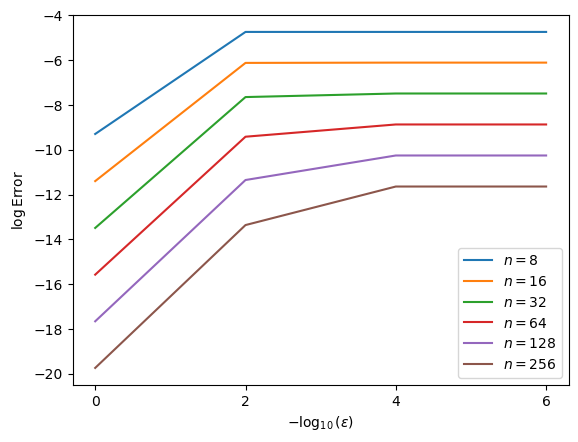

In [11]:
a = np.float64(0)
b = np.float64(0)

n_ls = [8, 16, 32, 64, 128, 256]

epsilons = np.array([10**-i for i in [0, 2, 4, 6]])

for n in n_ls:
    h = np.float64(1 / n)
    errs = [gen_error(n, h, a, b, epsilon) for epsilon in epsilons]

    plt.plot([0, 2, 4, 6], np.log(errs), label=f"$n = {n}$")

plt.xlabel(r"$-\log_{10}(\epsilon)$")
plt.xticks([0, 2, 4, 6])
plt.ylabel(r"$\log\text{Error}$")
plt.legend()

plt.savefig("3_c.png", dpi=300)

# d

In [12]:
from scipy.sparse.linalg import gmres

## Jacobi Method

$$
\underline{x}^{(k+1)} = \underline{x}^{(k)}+D^{-1}(\underline{b}-A\underline{x}^{(k)})
$$

In [13]:
def jacobi_method(
    A: np.ndarray, p: np.ndarray, tol: np.float64, max_iter: int, x_real: np.ndarray
) -> tuple[np.ndarray, int]:
    """Solve the linear system of equations Au=p using the Jacobi method."""
    D = np.diag(np.diag(A))
    inv_D = np.linalg.inv(D)
    x = np.zeros_like(p)

    for i in range(max_iter):
        x = np.dot(inv_D, p - np.dot(A, x)) + x
        err = np.sqrt(np.sum((x_real - x) ** 2) / (n - 1))
        if err < tol:
            return x, i + 1
    return x, max_iter

## Gauss Seidel Method

$$
\underline{x}^{(k+1)} = \underline{x}^{(k)}+(D+L)^{-1}(\underline{b}-A\underline{x}^{(k)})
$$


In [14]:
def gauss_seidel_method(
    A: np.ndarray, p: np.ndarray, tol: np.float64, max_iter: int, x_real: np.ndarray
) -> tuple[np.ndarray, int]:
    """Solve the linear system of equations Au=p using the Gauss Seidel method."""
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    inv_D_plus_L = np.linalg.inv(D + L)
    x = np.zeros_like(p)

    for i in range(max_iter):
        x = np.dot(inv_D_plus_L, p - np.dot(A, x)) + x
        err = np.sqrt(np.sum((x_real - x) ** 2) / (n - 1))
        if err < tol:
            return x, i + 1
    return x, max_iter

In [15]:
def GMRES_method(
    A: np.ndarray, p: np.ndarray, tol: np.float64, max_iter: int, _: np.ndarray
) -> tuple[np.ndarray, int]:
    """Solve the linear system of equations Au=p using the GMRES method."""
    iter_count = 1

    def callback(_: np.ndarray) -> None:
        nonlocal iter_count
        iter_count += 1

    result, info = gmres(
        A,
        p,
        rtol=0,
        atol=float(tol),
        maxiter=max_iter,
        callback=callback,
        callback_type="x",
    )

    if info != 0:
        return result, info
    return result, iter_count

In [16]:
max_iter = 10000
tol = np.float64(10**-10)

a = np.float64(0)
b = np.float64(0)
n_ls = [8, 16, 32, 64, 128, 256]

epsilons = np.array([10**-i for i in [0, 2, 4, 6]])

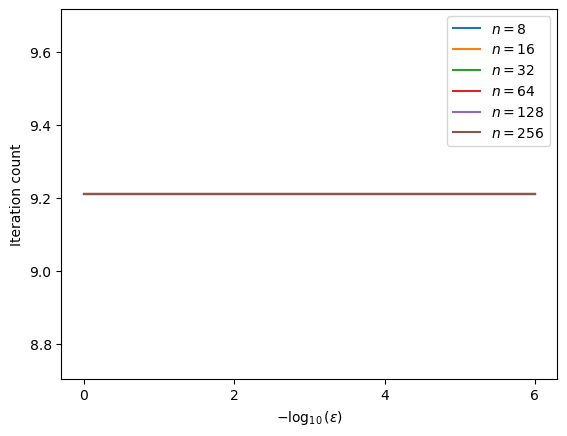

In [17]:
for n in n_ls:
    h = np.float64(1 / n)
    iters = []

    for epsilon in epsilons:
        x_real = gen_real_val(n, h, a, epsilon)
        A, p = gen_matrix(n, h, a, b, epsilon)
        i = jacobi_method(A, p, tol, max_iter, x_real)
        iters.append(i[1])

    plt.plot([0, 2, 4, 6], np.log(iters), label=f"$n = {n}$")

plt.xlabel(r"$-\log_{10}(\epsilon)$")
plt.xticks([0, 2, 4, 6])
plt.ylabel(r"Iteration count")
plt.legend()

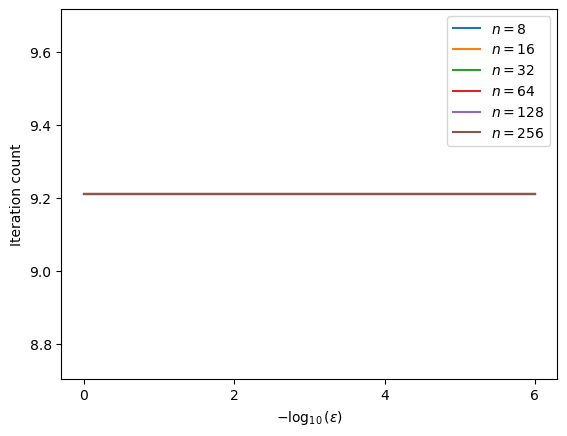

In [18]:
for n in n_ls:
    h = np.float64(1 / n)
    iters = []

    for epsilon in epsilons:
        x_real = gen_real_val(n, h, a, epsilon)
        A, p = gen_matrix(n, h, a, b, epsilon)
        i = gauss_seidel_method(A, p, tol, max_iter, x_real)
        iters.append(i[1])

    plt.plot([0, 2, 4, 6], np.log(iters), label=f"$n = {n}$")

plt.xlabel(r"$-\log_{10}(\epsilon)$")
plt.xticks([0, 2, 4, 6])
plt.ylabel(r"Iteration count")
plt.legend()

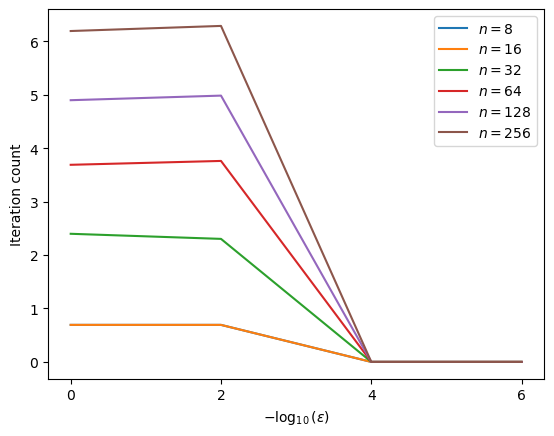

In [19]:
for n in n_ls:
    h = np.float64(1 / n)
    iters = []

    for epsilon in epsilons:
        x_real = gen_real_val(n, h, a, epsilon)
        A, p = gen_matrix(n, h, a, b, epsilon)
        i = GMRES_method(A, p, tol, max_iter, x_real)
        iters.append(i[1])

    plt.plot([0, 2, 4, 6], np.log(iters), label=f"$n = {n}$")

plt.xlabel(r"$-\log_{10}(\epsilon)$")
plt.xticks([0, 2, 4, 6])
plt.ylabel(r"Iteration count")
plt.legend()